## Proof of Concept for flood maps

This notebook is an attempt at translating the CoCliCo User Story into code. 

The data used is Coastal Flood Hazard Projections and can be found here: p:\11207608-coclico\FULLTRACK_DATA\WP4\

In [1]:
# Import modules

import warnings

# import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import shapely
import pandas as pd
import pystac_client
import xarray as xr
import rioxarray as rio
import pathlib
import pystac
import geopandas as gpd

#import colormaps as cmaps
import pyam # https://pyam-iamc.readthedocs.io/en/latest/index.html
import matplotlib.colors as mcolors

from copy import deepcopy
from typing import List, Dict

# ignore warnings
warnings.filterwarnings("ignore")

C:\Users\soest\AppData\Local\Temp\ipykernel_11392\811421884.py:18: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [2]:
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-cfhp/catalog.json"
)
collection = catalog.get_child(id = 'cfhp')

In [3]:
item = pystac.Item.from_file('https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-cfhp/cfhp/items/UNDEFENDED_MAPS/RP/1000/B01_epsg%3D3035_x%3D2366962_y%3D3777262.json')
ds = rio.open_rasterio(item.assets['band_data'].href)
ds

Exception: Could not read uri https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac-cfhp/cfhp/items/UNDEFENDED_MAPS/RP/1000/B01_epsg%3D3035_x%3D2366962_y%3D3777262.json

In [4]:
# Load LAU's 

# Set file path
lau_fp = r"p:\11207608-coclico\FASTTRACK_DATA\XX_LAU\LAU_RG_01M_2020_3035.shp"

# Load data
lau_data = gpd.read_file(lau_fp)

<Axes: >

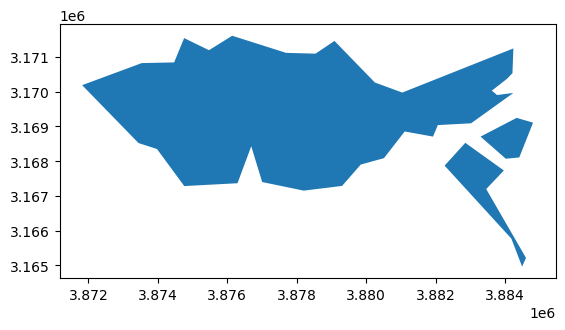

In [5]:
# Filter on the Netherlands as an example
lau_NL = lau_data.loc[lau_data["CNTR_CODE"] == "NL"] 

# Select one for testing
lau = lau_data.loc[lau_data["LAU_NAME"] == "Vlissingen"] 

lau.plot()

In [68]:
# intersecting_items = []
# for item in collection.get_items():
#     item_geometry = item.geometry
#     if item_geometry.intersects(lau['geometry'].unary_union):
#         intersecting_items.append(item)

AttributeError: 'dict' object has no attribute 'intersects'

In [6]:
for i, item in enumerate(collection.get_all_items()):
    
    if "UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=3186162_y=2958337.tif" in item.id:
        print(item.id)
        print(i)
        break


UNDEFENDED_MAPS/RP/1000/B01_epsg=3035_x=3186162_y=2958337.tif
912


In [7]:
from shapely.geometry import shape

cur_item_geom = gpd.GeoDataFrame(geometry=[shape(item.geometry)])

[item_geom] = item.properties['proj:geometry']['coordinates']

Working on: Vlissingen


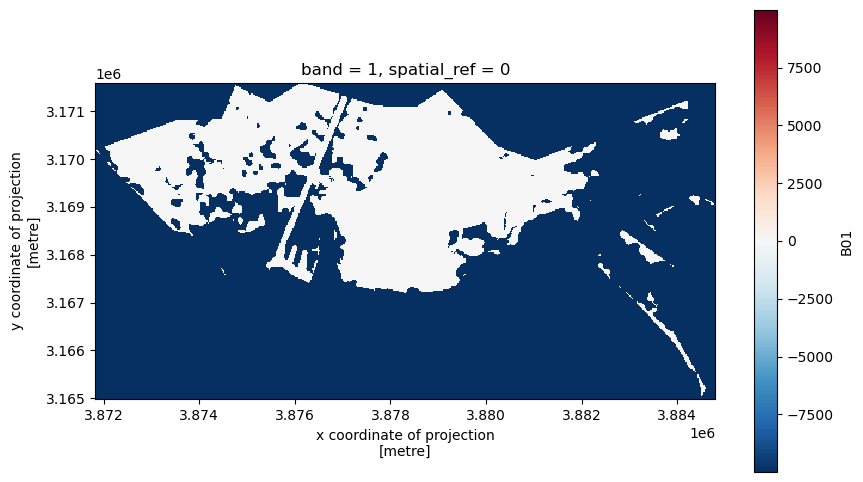

In [19]:
item_test = gpd.GeoDataFrame(geometry = [shapely.Polygon(item_geom)])

# Generate figure
f, ax = plt.subplots(figsize=(10, 6))
item_test.plot(ax=ax, color='lightgray', edgecolor='black')
lau_NL.plot(ax=ax, color='blue', edgecolor='black')
lau.plot(ax=ax, color='red')


for i, cur_lau in lau.iterrows():
    
    if cur_lau['geometry'].intersects(item_test['geometry'])[0]:
        
        print('Working on: ' + str(cur_lau['LAU_NAME']))
        # Load raw band_data dataset 
        ds = rio.open_rasterio(item.assets['band_data'].href)

        # Clip dataset to match AOI
        ds_clip = ds.rio.clip(cur_lau)

      


In [22]:
ds_clip

<xarray.DataArray (band: 1, y: 265, x: 519)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.872e+06 3.872e+06 ... 3.885e+06 3.885e+06
  * y            (y) float64 3.172e+06 3.172e+06 ... 3.165e+06 3.165e+06
    spatial_ref  int32 0
Attributes: (12/25)
    AREA_OR_POINT:       Area
    AUTHOR:              UC-IHC
    CITATION:            None.
    Conventions:         CF-1.8
    CRS:                 EPSG:3035
    DESCRIPTION:         This map represents the flood simulation across Euro...
    ...                  ...
    TITLE_ABBREVIATION:  RP1
    UNITS:               Meters (m)
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           B01
    _FillValue:          -9999.0

In [126]:
result = lau['geometry'].intersects(item_test['geometry'])

In [118]:
item_geoms = gpd.GeoDataFrame([{id:None}])
for i, item in enumerate(collection.get_all_items()):
    print(i)
    cur_item_geom = gpd.GeoDataFrame(geometry=[shape(item.geometry)])
    item_geoms = pd.concat([item_geoms,cur_item_geom])
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [75]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# Example GeoDataFrames (replace with your actual data)
multipolygon_gdf = gpd.GeoDataFrame(
    {'geometry': [MultiPolygon([Polygon([(0, 0), (2, 2), (0, 2), (0, 0)]),
                                 Polygon([(1, 1), (3, 3), (1, 3), (1, 1)])])]}
)

polygon_gdf = gpd.GeoDataFrame(
    {'geometry': [Polygon([(1, 0), (1, 3), (2, 2), (1, 0)])]}
)

# Check if the areas intersect
overlap = multipolygon_gdf['geometry'].intersects(polygon_gdf['geometry'])

# Print the result (True if overlapping, False otherwise)
print(overlap)

GEOSException: TopologyException: side location conflict at 1 1. This can occur if the input geometry is invalid.

In [174]:
item = pystac.Item.from_file('https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac/cfhp/items/UNDEFENDED_MAPS/RP/1000/B01_epsg%3D3035_x%3D3186162_y%3D2958062.json')
ds = rio.open_rasterio(item.assets['band_data'].href)

In [181]:
items = collection.get_all_items()

In [182]:
items